This is a slightly involved classification notebook - using superpixels to generate features. The results look good in that we reduce commission errors. The segmentation might be 

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from tqdm import tqdm
import rasterio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
# adding rscube to the system path
import sys
sys.path.insert(0, '../../')
from rscube.nd_tools import (get_array_from_features, 
                             get_features_from_array, 
                             get_superpixel_area_as_features, 
                             get_superpixel_means_as_features,
                             get_superpixel_stds_as_features, 
                             scale_img)
from rscube.rio_tools import (get_geopandas_features_from_array, 
                              rasterize_shapes_to_array, 
                              get_indices_from_extent, get_cropped_profile)

from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from pprint import pprint
import geopandas as gpd
from rasterio import plot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import geopandas as gpd
from shapely.geometry import box
from rasterio.windows import Window
from pathlib import Path
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile

Currently, we don't have a way to link chips and planet IDs we are using so this is manual.

In [42]:
PLANET_ID = '20210924_000522_94_2421_3B_AnalyticMS_SR_8b'

In [43]:
planet_image_path = Path(f'../../../local_chips/{PLANET_ID}.tif')
planet_image_path.exists()

True

# Load Chips

Want to crop image based on chip

In [44]:
df = gpd.read_file('../../chips.geojson')
df.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,-159.648125,69.21,3,3_38,2011-07-17,1,99,"POLYGON ((-159.89875 69.30000, -159.65900 69.3..."
1,-112.983750,67.05,4,4_27,2012-07-23,1,114,"POLYGON ((-113.21200 67.14000, -113.09850 67.1..."
2,17.698500,65.97,4,4_43,2010-07-24,1,20,"POLYGON ((17.61000 66.06000, 17.91700 66.06000..."
3,59.675000,65.79,3,3_1,2011-07-13,1,112,"POLYGON ((59.86900 65.88000, 59.89200 65.88000..."
4,-96.604375,62.73,4,4_34,2012-08-27,1,115,"POLYGON ((-96.79875 62.82000, -96.57700 62.820..."


In [45]:
with rasterio.open(planet_image_path) as ds:
    image_crs = ds.crs
    image_box = box(*ds.bounds)
    image_bounds = list(ds.bounds)
    image_profile = ds.profile
    image_shape = image_profile['height'], image_profile['width']

image_shape

(7024, 7056)

In [46]:
df_utm = df.to_crs(image_crs)
intersects = df_utm.geometry.intersects(image_box)
df_chip = df_utm[intersects].reset_index(drop=True)
df_chip.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,139.59,-17.01,4,4_42,2012-04-24,1,7,"POLYGON ((340065.892 8128684.824, 359851.101 8..."


It's a little weird because all Planet Imagery is in UTM and Chips are in Lon/Lat.

In [47]:
(start_y, start_x), (stop_y, stop_x) = get_indices_from_extent(image_profile['transform'],
                                                               list(df_chip.total_bounds),
                                                               shape=image_shape)
window = Window.from_slices((start_y, stop_y), (start_x, stop_x))
sx, sy = np.s_[start_x: stop_x], np.s_[start_y: stop_y]
profile_cropped = get_cropped_profile(image_profile, sx, sy)

We are going to label things based on the chip index.

In [48]:
index = df_chip.random_id[0]
index

7

In [10]:
with rasterio.open(planet_image_path) as ds:
    image_c = ds.read(window=window)
    image_c = image_c.transpose([1, 2, 0]).astype(np.float32)
image_c.shape

(6688, 6720, 8)

In [11]:
with rasterio.open(planet_image_path) as ds:

    t = ds.tags()
    d = ds.descriptions
    
list(enumerate(d))

[(0, None),
 (1, None),
 (2, None),
 (3, None),
 (4, None),
 (5, None),
 (6, None),
 (7, None)]

In [12]:
mask = (image_c[..., 0] == image_profile['nodata'])
image_c[mask, :] = np.nan

In [13]:
image = image_c[..., [7, 5, 3]]

image_view = image.copy()
for k in tqdm(range(3)):
    m0 = np.nanpercentile(image[~mask, k], 2)
    m1 = np.nanpercentile(image[~mask, k], 98)
    image_view[~mask, k] = np.clip(image[~mask, k], m0, m1)

100%|██████████| 3/3 [00:07<00:00,  2.64s/it]


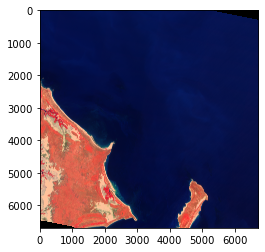

In [14]:
rgb = scale_img(image_view)
plt.imshow(rgb)

In [15]:
p_cropped = profile_cropped.copy()
p_cropped['count'] = 3
p_cropped['dtype'] = 'float32'
p_cropped['nodata'] = np.nan
with rasterio.open(f'cropped_to_chip_{index}.tif', 'w', **p_cropped) as ds:
    ds.write(rgb.transpose([2, 0, 1]))

# Generate Features

In [16]:
pixel_features = rgb.reshape((-1, rgb.shape[-1]))

In [17]:
all_features = np.hstack(([pixel_features]  
                          #+ superpixel_means_pixel_f 
                          #+ superpixel_stds_pixel_f
                         ))
all_features.shape

(44943360, 3)

# Generate Training Data

Using Peckel Occurance data to generate training data

In [18]:
from osgeo import gdal
from dem_stitcher.rio_window import read_raster_from_window
from rasterio.warp import transform_bounds

def build_peckel_vrt(extent: list, 
                     out_path: Path):
    df_peckel_data = gpd.read_file('../../../../marshak/auxiliary_water_masks/peckel_tiles.geojson')
    bbox = box(*extent)
    ind_inter = df_peckel_data.geometry.intersects(bbox)
    df_subset = df_peckel_data[ind_inter].reset_index(drop=True)
    gdal.BuildVRT(str(out_path), df_subset.source_url.tolist())
    return out_path

def get_peckel_raster(extent:list) -> tuple:
    tmp_vrt = Path('peckel_data_tmp.vrt')
    build_peckel_vrt(extent, tmp_vrt)
    X, p = read_raster_from_window(tmp_vrt,
                                   extent,
                                   CRS.from_epsg(4326))
    tmp_vrt.unlink()
    p['driver'] = 'GTiff'
    return X, p

In [19]:
X_occ, p_occ = get_peckel_raster(df_chip.to_crs(4326).total_bounds)

In [20]:
with rasterio.open(f'occurence_c{index}.tif', 'w', **p_occ) as ds:
    ds.write(X_occ, 1)

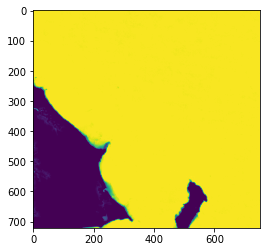

In [21]:
plt.imshow(X_occ)

In [22]:
from scipy import ndimage

OCC_MIN = 10
DIST_TO_EXTENT = 5

water_ind_pek = (X_occ >= OCC_MIN)
water_extent = (X_occ > 0)

water_extent_arr = (~water_extent).astype(int)
water_dist = ndimage.distance_transform_edt(water_extent_arr)

land_ind_pek = water_dist > DIST_TO_EXTENT

Text(0.5, 1.0, 'Land Mask')

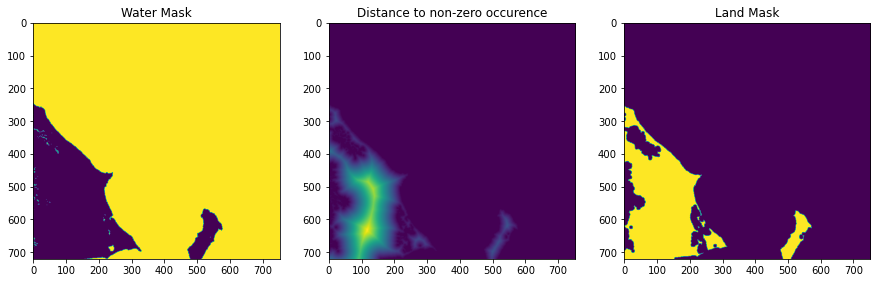

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].imshow(water_ind_pek)
ax[0].set_title('Water Mask')

ax[1].imshow(water_dist)
ax[1].set_title('Distance to non-zero occurence')

ax[2].imshow(land_ind_pek)
ax[2].set_title('Land Mask')

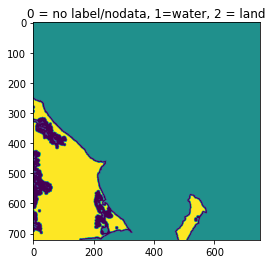

In [24]:
training_data = np.zeros(X_occ.shape)
training_data[land_ind_pek] = 2
training_data[water_ind_pek] = 1
plt.title('0 = no label/nodata, 1=water, 2 = land')
plt.imshow(training_data)

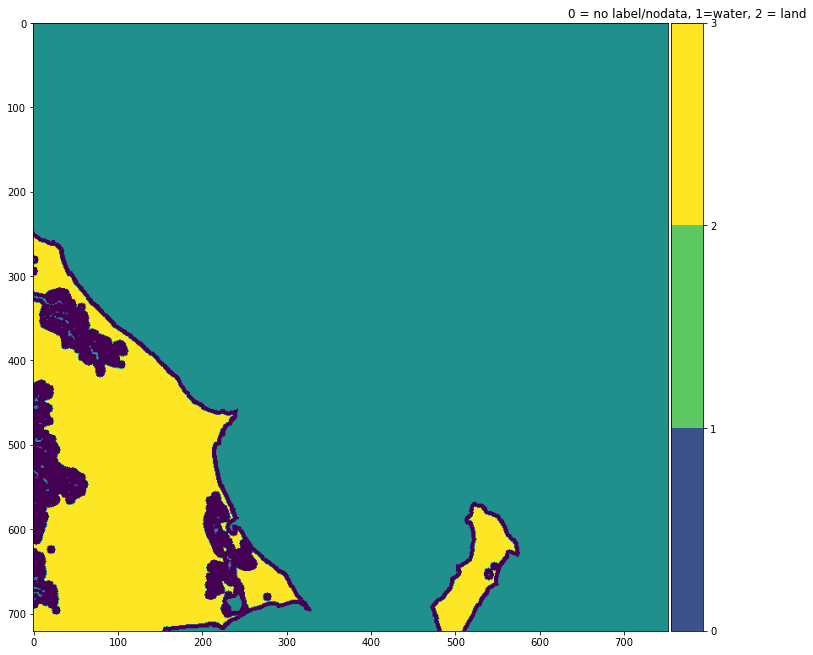

In [25]:
fig, axes = plt.subplots(figsize=(12, 12))
# initiate colorbar and control height of colorbar
divider = make_axes_locatable(axes)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
# set colorbounds
colorbarfmt='%.1i'
colorbounds = [0,1,2,3]
colorbounds_ticks = np.linspace(0, 3, 4)
# setup display
im = axes.imshow(training_data)
# colorbar
cbar_ax = fig.colorbar(im, spacing='proportional', ticks=colorbounds_ticks,
                        boundaries=colorbounds, format=colorbarfmt, pad=0.1, cax=cax)
# plot
plt.title('0 = no label/nodata, 1=water, 2 = land')
plt.show()

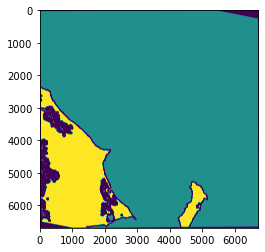

In [26]:
p_temp = p_occ.copy()
p_temp['dtype'] = 'float32'
p_temp['nodata'] = None

training_data_r, p_r = reproject_arr_to_match_profile(training_data, p_temp, p_cropped)
# rounding then casting makes sure the class assigned is closest after reprojection
training_data_r = training_data_r[0, ...]
training_data_r[mask] = 0

plt.imshow(training_data_r)

In [27]:
with rasterio.open('train_peckel.tif', 'w', **p_r) as ds:
    ds.write(training_data_r, 1)

# Unsupervised

Using Unsupervised classification to generate training data

In [28]:
# Number of classes
n_clusters = 10
# Maximum number of iterations of the k-means algorithm for a single run
max_iter = 10
# Number of time the k-means algorithm will be run with different centroid seeds
n_init = 10

In [29]:
clf = KMeans(n_clusters=n_clusters,
             max_iter=max_iter,
             n_init=n_init)

In [30]:
all_mask_unsuper = (mask.reshape((-1,)))

X_mask_unsuper = all_features[~all_mask_unsuper, 
                     ...]

In [31]:
labels = clf.fit_predict(X_mask_unsuper)
centers = clf.cluster_centers_
labels.shape

(44650018,)

In [32]:
# resize array and apply mask
y_arr_unsuper = np.zeros(mask.shape)

y_arr_unsuper[~mask] = labels
y_arr_unsuper[mask] = 0

## Make plot of raw image

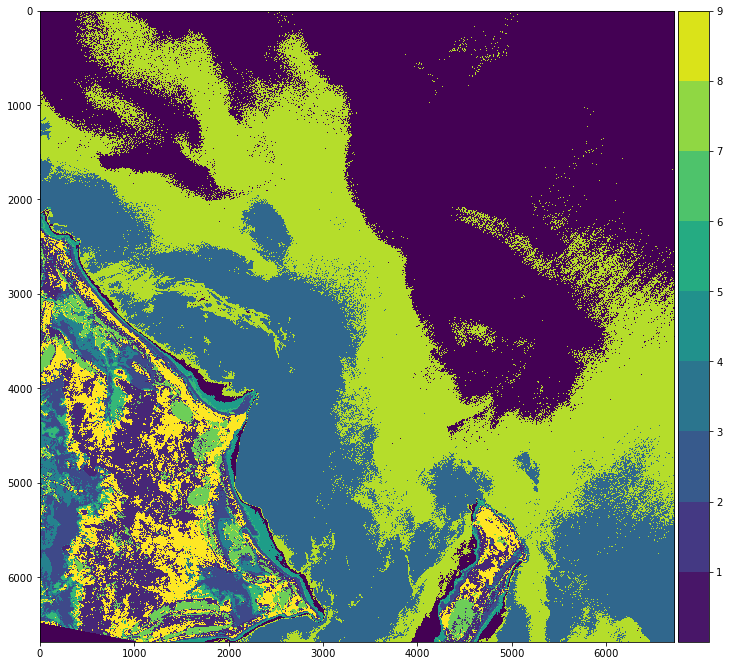

In [33]:
fig, axes = plt.subplots(figsize=(12, 12))
# initiate colorbar and control height of colorbar
divider = make_axes_locatable(axes)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
# set colorbounds
colorbarfmt='%.1i'
colorbounds = np.unique(y_arr_unsuper)
colorbounds_ticks = np.linspace(np.min(y_arr_unsuper)+1, np.max(y_arr_unsuper), len(colorbounds)-1)
# setup display
im = axes.imshow(y_arr_unsuper, interpolation='none')
# colorbar
cbar_ax = fig.colorbar(im, spacing='proportional', ticks=colorbounds_ticks,
                        boundaries=colorbounds, format=colorbarfmt, pad=0.1, cax=cax)
# plot
plt.show()

In [34]:
# save original classified image
p_unsuper = profile_cropped.copy()
p_unsuper['count'] = 1 # number of bands
p_unsuper['dtype'] = y_arr_unsuper.dtype
with rasterio.open(f'raw_unsupervised.tif', 'w', **p_unsuper) as ds:
    ds.write(y_arr_unsuper, 1)

## Automatically reclassify into water and non-water

In [35]:
def automate_labeling_of_clusters(label_arr, image, aux_data_arr, kmeans_model, N_samples = 15):
    from scipy.stats import mode
    
    mask = np.isnan(image[..., 0])
    X = image[~mask]
    labels_ = label_arr[~mask]
    aux_data_ = aux_data_arr[~mask]

    centers = kmeans_model.cluster_centers_
    unique_labels = sorted(np.unique(labels_))
    # assuming sorted labels correspond to centers in order they occur in cluster_centers_
    data_dict = dict(zip(unique_labels, centers))
    
    new_labels = {}
    
    for label, center in tqdm(data_dict.items()):
        distances = np.linalg.norm(X - center, axis=1)
        indices_sorted = np.argsort(distances)
        new_label = mode(aux_data_[indices_sorted[:N_samples]])[0][0]
        if new_label == 0.:
            new_label == 2.
        new_labels[label] = new_label
        
    return new_labels

In [36]:
d = automate_labeling_of_clusters(y_arr_unsuper, rgb, training_data_r, clf)

100%|██████████| 10/10 [01:38<00:00,  9.80s/it]


In [37]:
%%time

labels_auto = np.array([d[l] if l != 0 else 0 for l in tqdm(labels)])

100%|██████████| 44650018/44650018 [01:30<00:00, 495230.59it/s]


CPU times: user 1min 36s, sys: 1.29 s, total: 1min 37s
Wall time: 1min 37s


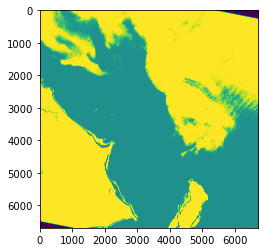

In [38]:
# resize array and apply mask
y_arr_unsuper_final = np.zeros(mask.shape)
y_arr_unsuper_final[~mask] = labels_auto

temp = y_arr_unsuper_final[~mask]
temp[temp == 0.] = 2

y_arr_unsuper_final[~mask] = temp

plt.imshow(y_arr_unsuper_final)

In [39]:
with rasterio.open('unsupervised_labeling_with_peckel.tif', 'w', **p_unsuper) as ds:
    ds.write(y_arr_unsuper_final, 1)